In [1]:
#r "nuget:Microsoft.Data.Analysis,0.21.0"

The below script needs to be able to find the current output cell; this is an easy method to get it.

Installed Packages Microsoft.Data.Analysis, 0.21.0

Loading extensions from `C:\Users\SPREATICS\.nuget\packages\microsoft.data.analysis\0.21.0\interactive-extensions\dotnet\Microsoft.Data.Analysis.Interactive.dll`

In [2]:
using Microsoft.Data.Analysis;

string[] names = { "Oliver", "Charlotte", "Henry", "Amelia", "Owen" };
int[] ages = { 23, 19, 42, 64, 35 };
double[] heights = { 1.91, 1.62, 1.72, 1.57, 1.85 };

DataFrameColumn[] columns = {
    new StringDataFrameColumn("Name", names),
    new PrimitiveDataFrameColumn<int>("Age", ages),
    new PrimitiveDataFrameColumn<double>("Height", heights),
};

DataFrame df = new(columns);


In [3]:
df

index,Name,Age,Height
0,Oliver,23,1.91
1,Charlotte,19,1.62
2,Henry,42,1.72
3,Amelia,64,1.57
4,Owen,35,1.85


In [4]:
List<KeyValuePair<string, object>> newRowData = new()
{
    new KeyValuePair<string, object>("Name", "Scott"),
    new KeyValuePair<string, object>("Age", 36),
    new KeyValuePair<string, object>("Height", 1.65),
};

df.Append(newRowData, inPlace: true);

In [5]:
df

index,Name,Age,Height
0,Oliver,23,1.91
1,Charlotte,19,1.62
2,Henry,42,1.72
3,Amelia,64,1.57
4,Owen,35,1.85
5,Scott,36,1.65


In [6]:
int[] weights = { 123, 321, 111, 121, 131, 141 };
PrimitiveDataFrameColumn<int> weightCol = new("Weight", weights);
df.Columns.Add(weightCol);

In [7]:
df

index,Name,Age,Height,Weight
0,Oliver,23,1.91,123
1,Charlotte,19,1.62,321
2,Henry,42,1.72,111
3,Amelia,64,1.57,121
4,Owen,35,1.85,131
5,Scott,36,1.65,141


In [8]:
df.OrderBy("Name")
    .Filter(df["Age"].ElementwiseGreaterThan(30))

index,Name,Age,Height,Weight
0,Henry,42,1.72,111
1,Oliver,23,1.91,123
2,Owen,35,1.85,131
3,Scott,36,1.65,141


In [9]:
df.Filter(df["Age"].ElementwiseGreaterThan(30))

index,Name,Age,Height,Weight
0,Henry,42,1.72,111
1,Amelia,64,1.57,121
2,Owen,35,1.85,131
3,Scott,36,1.65,141


In [17]:
var filteredRows = df.Rows
            .Where(row => (int)row["Age"] >= 30)
            .ToList();
filteredRows

index value 0 [ Henry, 42, 1.72, 111 ] (values) index type value 0 System.String Henry 1 System.Int32 42 2 System.Double 1.72 3 System.Int32 111 1 [ Amelia, 64, 1.57, 121 ] (values) index type value 0 System.String Amelia 1 System.Int32 64 2 System.Double 1.57 3 System.Int32 121 2 [ Owen, 35, 1.85, 131 ] (values) index type value 0 System.String Owen 1 System.Int32 35 2 System.Double 1.85 3 System.Int32 131 3 [ Scott, 36, 1.65, 141 ] (values) index type value 0 System.String Scott 1 System.Int32 36 2 System.Double 1.65 3 System.Int32 141

In [14]:
var selectedNames = df.Rows
            .Where(row => (int)row["Age"] >= 30)
            .Select(row => row["Name"].ToString())
            .ToList();
selectedNames

[ Henry, Amelia, Owen, Scott ]

In [12]:
df.OrderBy("Name")

index,Name,Age,Height,Weight
0,Amelia,64,1.57,121
1,Charlotte,19,1.62,321
2,Henry,42,1.72,111
3,Oliver,23,1.91,123
4,Owen,35,1.85,131
5,Scott,36,1.65,141


In [13]:
df.OrderBy("Name").Filter(df["Age"].ElementwiseGreaterThan(30))

index,Name,Age,Height,Weight
0,Henry,42,1.72,111
1,Oliver,23,1.91,123
2,Owen,35,1.85,131
3,Scott,36,1.65,141


In [14]:
var orderedDf = df.OrderBy("Name");
var filteredDf = orderedDf.Filter(orderedDf["Age"].ElementwiseGreaterThan(30));
filteredDf

index,Name,Age,Height,Weight
0,Amelia,64,1.57,121
1,Henry,42,1.72,111
2,Owen,35,1.85,131
3,Scott,36,1.65,141


In [15]:
DataFrameColumn iqCol = df["Age"] * df["Height"] * 1.5;

double[] iqs = Enumerable.Range(0, (int)iqCol.Length)
    .Select(x => (double)iqCol[x])
    .ToArray();

df.Columns.Add(new PrimitiveDataFrameColumn<double>("IQ", iqs));
df

index,Name,Age,Height,Weight,IQ
0,Oliver,23,1.91,123,65.895
1,Charlotte,19,1.62,321,46.17
2,Henry,42,1.72,111,108.35999999999999
3,Amelia,64,1.57,121,150.72
4,Owen,35,1.85,131,97.125
5,Scott,36,1.65,141,89.1


In [16]:
private static (double mean, double std) MeanAndStd(double[] values)
{
	if (values is null)
		throw new ArgumentNullException(nameof(values));

	if (values.Length == 0)
		throw new ArgumentException($"{nameof(values)} must not be empty");

	double sum = 0;
	for (int i = 0; i < values.Length; i++)
		sum += values[i];

	double mean = sum / values.Length;

	double sumVariancesSquared = 0;
	for (int i = 0; i < values.Length; i++)
	{
		double pointVariance = Math.Abs(mean - values[i]);
		double pointVarianceSquared = Math.Pow(pointVariance, 2);
		sumVariancesSquared += pointVarianceSquared;
	}

	double meanVarianceSquared = sumVariancesSquared / values.Length;
	double std = Math.Sqrt(meanVarianceSquared);

	return (mean, std);
}

In [17]:
foreach (DataFrameColumn col in df.Columns.Skip(1))
{
    // warning: additional care must be taken for datasets which contain null
    double[] values = Enumerable.Range(0, (int)col.Length).Select(x => Convert.ToDouble(col[x])).ToArray();
    (double mean, double std) = MeanAndStd(values);
    Console.WriteLine($"{col.Name} = {mean} +/- {std:N3} (n={values.Length})");
}

Age = 36.5 +/- 14.592 (n=6)
Height = 1.72 +/- 0.123 (n=6)
Weight = 158 +/- 73.473 (n=6)
IQ = 92.895 +/- 32.983 (n=6)


In [18]:
DataFrame.SaveCsv(df, "result.csv", ',');

In [ ]:
#r "nuget:ScottPlot, 5.0.36"

Installed Packages ScottPlot, 5.0.36

Loading extensions from `C:\Users\gamec\.nuget\packages\skiasharp\2.88.8\interactive-extensions\dotnet\SkiaSharp.DotNet.Interactive.dll`

In [ ]:
using Microsoft.DotNet.Interactive.Formatting;
using ScottPlot;

In [ ]:
Formatter.Register(typeof(ScottPlot.Plot), (plt, writer) => 
    writer.Write(((ScottPlot.Plot)plt).GetImageHtml(300,400)), HtmlFormatter.MimeType);

In [ ]:
double[] ages = Enumerable.Range(0, (int)df.Rows.Count).Select(x => Convert.ToDouble(df["Age"][x])).ToArray();
double[] heights = Enumerable.Range(0, (int)df.Rows.Count).Select(x => Convert.ToDouble(df["Height"][x])).ToArray();


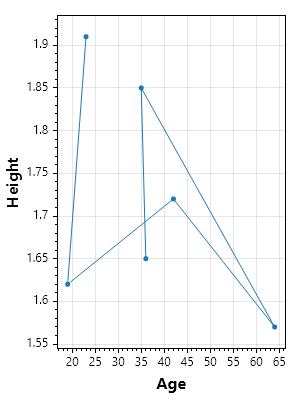

In [ ]:
var plt = new ScottPlot.Plot();
plt.Add.Scatter(ages, heights);
plt.XLabel("Age");
plt.YLabel("Height");
plt


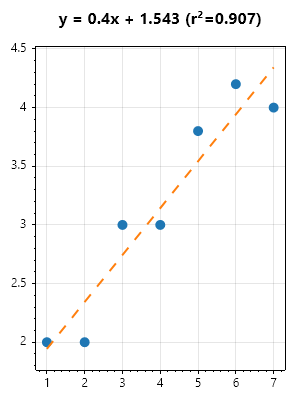

In [ ]:
ScottPlot.Plot myPlot = new();

double[] xs = new double[] { 1, 2, 3, 4, 5, 6, 7 };
double[] ys = new double[] { 2, 2, 3, 3, 3.8, 4.2, 4 };

// plot original data as a scatter plot
var sp = myPlot.Add.Scatter(xs, ys);
sp.LineWidth = 0;
sp.MarkerSize = 10;

// calculate the regression line
ScottPlot.Statistics.LinearRegression reg = new(xs, ys);

// plot the regression line
Coordinates pt1 = new(xs.First(), reg.GetValue(xs.First()));
Coordinates pt2 = new(xs.Last(), reg.GetValue(xs.Last()));
var line = myPlot.Add.Line(pt1, pt2);
line.MarkerSize = 0;
line.LineWidth = 2;
line.LinePattern = LinePattern.Dashed;

// note the formula at the top of the plot
myPlot.Title(reg.FormulaWithRSquared);

// myPlot.SavePng("demo.png", 400, 300);
myPlot

r은 결정계수를 의미, 1에 가까울수록 모델이 데이터를 잘 설명한다는 것을 의미